In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Added in functions for model solving used previously:

In [3]:
# setup code from previous notebook

# degradation
def deg(x, dm):
    return x * dm

# ribosome binding
def r_b(mx, r, kb):
    return kb * mx * r  

# ribosome unbinding
def r_ub(cx, ku):
    return cx * ku

# transcription rate
def tx(w, theta, a, q=None, Kq=None, nq=None): 
    if q is not None and Kq is not None and nq is not None:
        return (w * a / (theta + a)) / (1 + (q / (Kq )) ** nq)
    else:
        return w * a / (theta + a)

# translation rate
def tlr(a, nx, cx, gmax, Kgamma):
    gamma = gmax * a / (Kgamma + a) 
    return (gamma / nx) * cx

# energy consumption
def ttrate(a, cr, ct, cm, cq, gmax, Kgamma):
    gamma = gmax * a / (Kgamma + a)
    return (cr + ct + cm + cq) * gamma

# import 
def vimp(et, vt, s0, Kt):
    return et * vt * s0 / (Kt + s0)

# metabolism
def vcat(em, si, vm, Km):
    return em * vm * si / (Km + si)

# growth rate
def lam(a, cr, ct, cm, cq, gmax, Kgamma, M):
    gamma = gmax * a / (Kgamma + a)
    ttrate = (cr + ct + cm + cq) * gamma
    lam = ttrate / M
    return lam

# antibiotic binding
def abx_bind(cx, Cm, k_cm):
    return cx * Cm * k_cm   

In [4]:
# model from growth_model_ode notebook or add your own from previously completed notebook

def abx_model(t, y, params):

    # parameters 
    dm, kb, ku, thetar, s0, gmax, thetax, Kt, M, we, Km, vm, nx, Kq, vt, wr, wq, nq, nr, ns, Kgamma, Cm, k_cm = params

    # species (LHS)
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a, zmt, zmm, zmq, zmr = y
    
    # RHS of ODE
    dydt = np.zeros(18) # the order of the RHS will match the order of species in y eg. dydt[0] = dmt/dt, dydt[1] = dmm/dt, dydt[2] = dmq/dt etc.

    # this model is just an extension of the previous one, so we will repeat the same steps with the addition of antibiotic binding 
    # transcription
    dmtdt = tx(we, thetax, a)
    dmmdt = tx(we, thetax, a)
    dmqdt = tx(wq, thetax, a, q=q, Kq=Kq, nq=nq)
    dmrdt = tx(wr, thetar, a)

    # mRNA degradation 
    dmtdt -= deg(mt, dm)
    dmmdt -= deg(mm, dm)
    dmqdt -= deg(mq, dm)
    dmrdt -= deg(mr, dm)

    # ribosome binding
    dmtdt -= r_b(mt, r, kb)
    dmmdt -= r_b(mm, r, kb)
    dmqdt -= r_b(mq, r, kb)
    dmrdt -= r_b(mr, r, kb)

    dctdt = r_b(mt, r, kb)
    dcmdt = r_b(mm, r, kb)
    dcqdt = r_b(mq, r, kb)
    dcrdt = r_b(mr, r, kb)

    drdt =  - r_b(mt, r, kb) - r_b(mm, r, kb) - r_b(mq, r, kb) - r_b(mr, r, kb)

    # ribosome unbinding 
    dmtdt += r_ub(ct, ku)
    dmmdt += r_ub(cm, ku)
    dmqdt += r_ub(cq, ku)
    dmrdt += r_ub(cr, ku)

    dctdt -= r_ub(ct, ku)
    dcmdt -= r_ub(cm, ku)
    dcqdt -= r_ub(cq, ku)
    dcrdt -= r_ub(cr, ku)

    drdt += r_ub(ct, ku) + r_ub(cm, ku) + r_ub(cq, ku) + r_ub(cr, ku)

    # translation
    dmtdt += tlr(a, nx, ct, gmax, Kgamma)
    dmmdt += tlr(a, nx, cm, gmax, Kgamma)
    dmqdt += tlr(a, nx, cq, gmax, Kgamma)
    dmrdt += tlr(a, nr, cr, gmax, Kgamma)

    dctdt -= tlr(a, nx, ct, gmax, Kgamma)
    dcmdt -= tlr(a, nx, cm, gmax, Kgamma)
    dcqdt -= tlr(a, nx, cq, gmax, Kgamma)
    dcrdt -= tlr(a, nr, cr, gmax, Kgamma)

    detdt = tlr(a, nx, ct, gmax, Kgamma)
    demdt = tlr(a, nx, cm, gmax, Kgamma)
    dqdt = tlr(a, nx, cq, gmax, Kgamma)
    drdt += tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nx, ct, gmax, Kgamma) + tlr(a, nx, cm, gmax, Kgamma) + tlr(a, nx, cq, gmax, Kgamma)

    # nutrient import
    dsidt = vimp(et, vt, s0, Kt)

    # metabolism
    dsidt -= vcat(em, si, vm, Km)
    dadt = (ns*vcat(em, si, vm, Km))

    # energy consumption
    dadt -= ttrate(a, cr, ct, cm, cq, gmax, Kgamma)

    # dilution by growth 
    dmtdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mt)
    dmmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mm)
    dmqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mq)
    dmrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mr)

    dctdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * ct)   
    dcmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cm)   
    dcqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cq)
    dcrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cr)

    detdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * et)
    demdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * em)
    dqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * q)
    drdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * r)

    dsidt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * si)
    dadt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * a)

    # antibiotic binding
    dctdt -= abx_bind(ct, Cm, k_cm)
    dcmdt -= abx_bind(cm, Cm, k_cm)
    dcqdt -= abx_bind(cq, Cm, k_cm)
    dcrdt -= abx_bind(cr, Cm, k_cm)

    dzmtdt = abx_bind(ct, Cm, k_cm)
    dzmmdt = abx_bind(cm, Cm, k_cm)
    dzmqdt = abx_bind(cq, Cm, k_cm)
    dzmrdt = abx_bind(cr, Cm, k_cm)

    # dilution for new zombie species
    dzmtdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmt)
    dzmmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmm)
    dzmqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmq)
    dzmrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmr)

    # build full dydt system
    dydt[0] = dmtdt
    dydt[1] = dmmdt
    dydt[2] = dmqdt
    dydt[3] = dmrdt
    dydt[4] = dctdt
    dydt[5] = dcmdt
    dydt[6] = dcqdt
    dydt[7] = dcrdt
    dydt[8] = detdt
    dydt[9] = demdt
    dydt[10] = dqdt
    dydt[11] = drdt
    dydt[12] = dsidt
    dydt[13] = dadt

    # new species
    dydt[14] = dzmtdt
    dydt[15] = dzmmdt
    dydt[16] = dzmqdt
    dydt[17] = dzmrdt


    return dydt

    

New population model:

In [5]:
def popmodel_ode(t, y, params):

    # parameters 
    dm, kb, ku, thetar, s0, gmax, thetax, Kt, M, we, Km, vm, nx, Kq, vt, wr, wq, nq, nr, ns, Kgamma, Cm, k_cm, kin, kdeath = params

    # ensure no negative concentrations
    y = np.maximum(y, 0)
    
    # species (LHS)
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a, zmt, zmm, zmq, zmr, s, N = y

    cell = y[:-2]
    cell_params = list(params[:-2])
    cell_params[4] = s  # update external nutrient concentration in params with species 
    dcelldt = abx_model(t, cell, cell_params) # insert your model in here

    # extracellular ODEs
    # nutrient influx and consumption
    v_imp   = et * vt * s / (Kt + s)
    dsdt    = kin - N * v_imp

    # population growth 
    gamma   = gmax * a / (Kgamma + a)
    lam  = gamma/M * (cr + ct + cm + cq)
    dNdt    = N * (lam - kdeath)

    return np.concatenate([dcelldt, [dsdt], [dNdt]])

Parameters and initial conditions:

In [6]:
params_dict = {
    'dm': 0.1,
    'kb': 1,
    'ku': 1.0,
    'thetar': 426.8693338968694,
    's0': 1e4,
    'gmax': 1260.0,
    'thetax': 4.379733394834643,
    'Kt': 1.0e3,
    'M': 1.0e8,
    'we': 4.139172187824451,
    'Km': 1.0e3,
    'vm': 5800.0,
    'nx': 300.0,
    'Kq': 1.522190403737490e+05,
    'vt': 726.0,
    'wr': 929.9678874564831,
    'wq': 948.9349882947897,
    'nq': 4,
    'nr': 7549.0,
    'ns': 0.5,
    'Kgamma': 3e9,
    'Cm': 0,
    'k_cm': 0.005990373118888,
    'kin': 0,
    'kdeath': 0
}

def params_for_sim(param_dict):
    order = ['dm', 'kb', 'ku', 'thetar', 's0', 'gmax', 'thetax', 'Kt', 'M', 'we', 'Km', 'vm', 'nx', 'Kq', 'vt', 'wr', 'wq', 'nq', 'nr', 'ns', 'Kgamma', 'Cm', 'k_cm', 'kin', 'kdeath']
    return [param_dict[key] for key in order]

params = params_for_sim(params_dict)

init_dict = {
    'mt_0': 0.,
    'mm_0': 0.,
    'mq_0': 0.,
    'mr_0': 0.,
    'ct_0': 0.,
    'cm_0': 0.,
    'cq_0': 0.,
    'cr_0': 0.,
    'et_0': 1.,
    'em_0': 1.,
    'q_0': 0.,
    'r_0': 1.0,
    'si_0': 0.,
    'a_0':  0.0,
    'zmt_0':0, 
    'zmm_0':0, 
    'zmq_0':0, 
    'zmr_0':0,
    's_0' : 1e12,
    'N_0' : 1
}

def init_for_sim(init_dict):
    order = ['mt_0', 'mm_0', 'mq_0', 'mr_0', 'ct_0', 'cm_0', 'cq_0', 'cr_0', 'et_0', 'em_0', 'q_0', 'r_0', 'si_0', 'a_0', 'zmt_0', 'zmm_0', 'zmq_0', 'zmr_0', 's_0', 'N_0']
    return [init_dict[key] for key in order]

init = init_for_sim(init_dict)

Initially solve the cell growth model to steady state so we start the simulations with more realistic initial conditions:

In [7]:
sol = solve_ivp(abx_model, (0, 1e9), init[:-2], args=(params[:-2],), method='Radau')

init_pop = np.concatenate([sol.y[:, -1], [init_dict['s_0']], [init_dict['N_0']]])


Solve the population model with these new initial conditions and plot the population over time:

Text(0, 0.5, 'Population size')

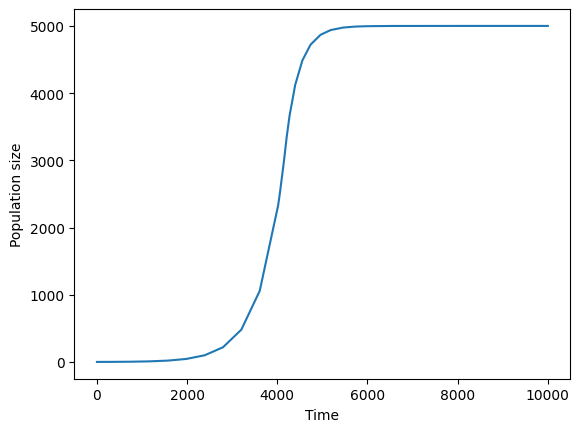

In [8]:
sol_pop = solve_ivp(popmodel_ode, (0, 10000), init_pop, args=(params,), method='Radau')
plt.plot(sol_pop.t, sol_pop.y[-1])
plt.xlabel('Time')
plt.ylabel('Population size')

### Competition between populations

We want to simulate competition by using different models to represent different populations. We can do this by changing specific parameter values except `nx, nq, nr, we, wr, wq, k_cm, ns, s0, gmax, M, kin`. Firstly, we need a model to simulate this:

In [9]:
def competition_ode(t, y, params):

    # ensure no negative concentrations
    y = np.maximum(y, 0)

    pop1 = y[:len(y)//2] # population 1 is the first half of y
    pop2 = y[len(y)//2:] # population 2 is the second half of y

    par1 = params[:len(params)//2] # parameters for pop1 is the first half of params
    par2 = params[len(params)//2:] # parameters for pop2 is the second half of params

    dpop1dt = popmodel_ode(t, pop1, par1) # run the population model for pop1
    dpop2dt = popmodel_ode(t, pop2, par2) # run the population model for pop2

    kin = par1[-2] # kin is the same for both populations, so we can just take it from par1
    dsdt = - kin + dpop1dt[-2] + dpop2dt[-2] # update dsdt to be the sum of both populations minus kin as it's already included in both

    dpop1dt[-2] = dsdt 
    dpop2dt[-2] = dsdt

    return np.concatenate([dpop1dt, dpop2dt])


We need two sets of parameters. We will give the first model our initial set of parameters from above and in the second model we will change `thetax`:

In [10]:
params_new_dict = params_dict.copy()
params_new_dict['parameter'] = ... # modify as needed
params_new = params_for_sim(params_new_dict)

params_full = np.concatenate([params, params_new])

Again, we will run the cell growth model to steady state for these two sets of parameters:

In [11]:
sol1 = solve_ivp(abx_model, (0, 1e9), init[:-2], args=(params[:-2],), method='Radau')
sol2 = solve_ivp(abx_model, (0, 1e9), init[:-2], args=(params_new[:-2],), method='Radau')

cell1 = np.concatenate([sol1.y[:, -1], [init_dict['s_0']], [init_dict['N_0']]])
cell2 = np.concatenate([sol2.y[:, -1], [init_dict['s_0']], [init_dict['N_0']]])

init_full = np.concatenate([cell1, cell2])

Now we can run the competition model with the new initial conditions and see which population wins:

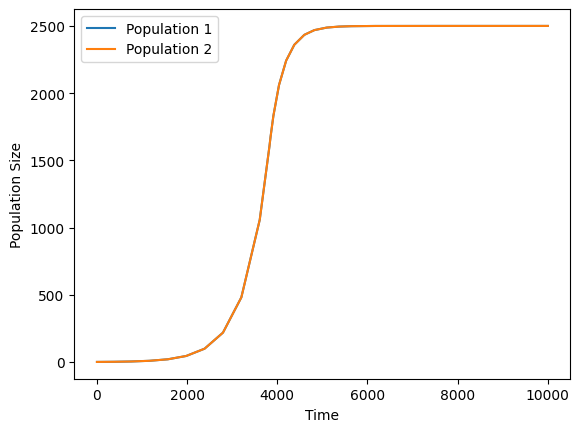

In [13]:
sol_comp = solve_ivp(competition_ode, (0, 1e4), init_full, args=(params_full,), method='Radau')

plt.plot(sol_comp.t, sol_comp.y[19], label='Population 1')
plt.plot(sol_comp.t, sol_comp.y[39], label='Population 2')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.legend()

## Next steps: 

#### In teams, try to build the most robust population, we will then put them up against eachother in different environmental conditions.